In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()
using Plots, QuadGK, Dierckx, SpecialFunctions, LaTeXStrings
V(x) = x^4/4 - x^2/2


  Activating project at `~/Desktop/tpt_code`


V (generic function with 1 method)

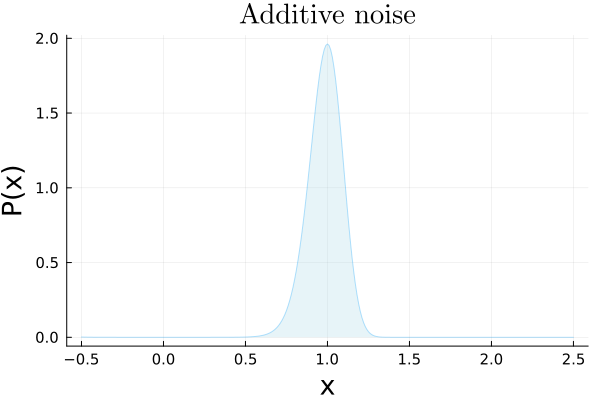

In [2]:
sigma = 0.3
rg = -0.5:0.01:2.5
Ps_add(x, sigma) = 1/sigma^2 * exp.((-2*V.(x))/sigma^2)
Nps, error = quadgk(x -> Ps_add(x, 0.2), -Inf, Inf, rtol=1e-8)
plot(rg, Ps_add(rg, 0.2)/Nps, fillrange = zero(rg), fc=:blues, alpha=0.3, xlab = "x", ylab = "P(x)", label = false,  title = "Additive noise", titlefont = font(18,"Computer Modern"), labelsize = 2,  ytickfont=font(10), xtickfont=font(10), guidefont=font(18), legenfont = font(18))


In [3]:
#export the tpt statistics for additive noise
function find_value(sigma)
    Ps_add(x) = 1/sigma^2 * exp((-2*V(x))/sigma^2)
    Nps, error = quadgk(x -> Ps_add(x), -Inf, Inf, rtol=1e-8)
    dq(x) = exp(2*V(x)/sigma^2)
    Nq, error = quadgk(x -> dq(x), -0.8, 0.8, rtol=1e-8)
    x_grid = range(-0.8,0.8,10^5)
    q_grid = zeros(100000)
    for i in 1:100000
        q_grid[i] = quadgk(x -> dq(x), -0.8, x_grid[i], rtol=1e-8)[1]
        q_grid[i]  = q_grid[i]/Nq
    end
    muAB_grid = Ps_add.(x_grid)/Nps.*q_grid.*(1 .-q_grid)
    spl = Spline1D(x_grid, muAB_grid)
    NmuAB = integrate(spl, -0.8, 0.8)
    
    JAB = 1/2*Ps_add.(x_grid)*sigma^2 .*dq.(x_grid)*1/Nps
    Vab, error =  quadgk(x -> dq(x)^2*sigma^2*Ps_add(x)*1/2/Nps, -0.8, 0.8, rtol=1e-8)
return x_grid, muAB_grid/NmuAB, q_grid, JAB, Ps_add.(-2:0.01:2)/Nps, Vab, NmuAB/Vab
end


find_value (generic function with 1 method)

In [4]:
#export the height of reactive probability density
function get_density_height(sigma)
    Ps_add(x) = 1/sigma^2 * exp((-2*V(x))/sigma^2)
    Nps, error = quadgk(x -> Ps_add(x), -Inf, Inf, rtol=1e-8)
    dq(x) = exp(2*V(x)/sigma^2)
    Nq, error = quadgk(x -> dq(x), -0.8, 0.8, rtol=1e-8)
    x_grid = range(-0.8,0.8,10^5)
    q_grid = zeros(100000)
    for i in 1:100000
        q_grid[i] = quadgk(x -> dq(x), -0.8, x_grid[i], rtol=1e-8)[1]
        q_grid[i]  = q_grid[i]/Nq
    end
    muAB_grid = Ps_add.(x_grid)/Nps.*q_grid.*(1 .-q_grid)
    spl = Spline1D(x_grid, muAB_grid)
    NmuAB = integrate(spl, -0.8, 0.8)
    index = findmin(abs.(x_grid))[2] # find the index where x = 0
    return muAB_grid[index]/NmuAB
end

get_density_height (generic function with 1 method)

In [5]:
heights = zeros(length(0.12:0.01:3))
for i = 1:length(heights)
    sigma = (0.12:0.01:10)[i]
    heights[i] = get_density_height(sigma)
end

asymptot = get_density_height(10)
plot(0.12:0.01:3, heights,labelsize = 2,  ytickfont=font(12), xtickfont=font(12), guidefont=font(25), legendfont = font(14), size = (600, 400), label = L"\rho_{AB}(0)", framestyle = :box)
hline!([asymptot], linestyle=:dash, label = L"\textrm{Density}",grid = false, xlab = L"\sigma", ylab = L"Transition\ rate", title = L"Stability", legend =:topright,foreground_color_legend = nothing, size = (600,400))
savefig("figure/Stability.pdf")


"/Users/yujingl3/Desktop/tpt_code/figure/Stability.pdf"

In [6]:
#obtain and plot reactive density for different noise strength under additive noise
x_grid1, muAB_grid1, q_grid1, JAB1, Ps1, Vab1, mfpt1= find_value(0.2)
x_grid1, muAB_grid2, q_grid2, JAB2, Ps2, Vab2, mfpt2= find_value(0.6)
x_grid1, muAB_grid3, q_grid3, JAB3, Ps3, Vab3, mfpt3= find_value(2.5)
p1 = plot(x_grid1, muAB_grid1, label = L"\sigma = 0.20", labelsize = 1.5,  ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legendfont = font(14), size = (600,400), framestyle = :box);
plot!(x_grid1, muAB_grid2, label = L"\sigma = 0.60");
plot!(x_grid1, muAB_grid3, label = L"\sigma = 2.5", xlab = L"x",ylab = L"\rho_{AB}(x)" ,legend =:topright,foreground_color_legend = nothing, grid = false, title = "Additive noise", titlefont = font(25))
savefig("figure/density_1d_additive.pdf")
p1

In [7]:
#export the tpt statistics for multiplicative noise
function find_value_mul(sigma)
    g(x) = sigma/4*(x^4 - 4*x^2 + 8)
    Ps_mul(x) = 16/sigma^2 * exp(-2*log(x^4-4x^2+8)+1/sigma^2*(atan(1-x^2/2)-2*(x^2-6)/(x^4-4x^2+8)))
    Nps, error = quadgk(x -> Ps_mul(x), -Inf, Inf, rtol=1e-5)
    x_grid = range(-1.5,0,10^5);
    min_index = findmax(Ps_mul.(x_grid))[2];
    left_min = x_grid[min_index];
    right_min = -left_min;
    dq(x) = exp(32*(1/32*(atan(1/2*(-2+x^2)))+(-6+x^2)/(16*(8-4x^2+x^4)))/sigma^2)
    Nq, error = quadgk(x -> dq(x), left_min+0.2, right_min-0.2, rtol=1e-5)
    x_grid = range(left_min+0.2,right_min-0.2,10^5)
    q_grid = zeros(100000)
    for i in 1:100000
        q_grid[i] = quadgk(x -> dq(x), left_min+0.2, x_grid[i], rtol=1e-5)[1]
        q_grid[i]  = q_grid[i]/Nq
    end
    muAB_grid = Ps_mul.(x_grid)/Nps.*q_grid.*(1 .-q_grid)
    spl = Spline1D(x_grid, muAB_grid)
   NmuAB = integrate(spl, left_min+0.2, right_min-0.2)
    JAB = 1/2*Ps_mul.(x_grid).*g.(x_grid).^2 .*dq.(x_grid)*1/Nps
    Vab, error =  quadgk(x -> dq(x)^2*g(x)^2*Ps_mul(x)*1/2/Nps, left_min+0.2, right_min-0.2, rtol=1e-5)
return x_grid, muAB_grid/NmuAB, q_grid, JAB, Ps_mul.(-2:0.01:2)/Nps, Vab, NmuAB/Vab
end

find_value_mul (generic function with 1 method)

In [8]:
x_grid_mul1, muAB_grid_mul1, q_grid1, JAB1, _, _,_= find_value_mul(0.2)
x_grid_mul2, muAB_grid_mul2, q_grid2, _, _, _,_= find_value_mul(0.6)
x_grid_mul3, muAB_grid_mul3, q_grid3, _, _, _,_= find_value_mul(2.5)

p2=plot(x_grid_mul1, muAB_grid_mul1, label = L"\sigma = 0.20", labelsize = 1.5,  ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legendfont = font(14), size = (600, 400), framestyle = :box);
plot!(x_grid_mul2, muAB_grid_mul2, label = L"\sigma = 0.60");
plot!(x_grid_mul3, muAB_grid_mul3, label = L"\sigma = 2.5", xlab = L"x",ylab = "" ,legend =:topright,foreground_color_legend = nothing, grid = false, title ="Multiplicative noise", labelsize = 1.5, titlefont = font(25))
savefig("figure/density_1d_multiplicative.pdf")
p2

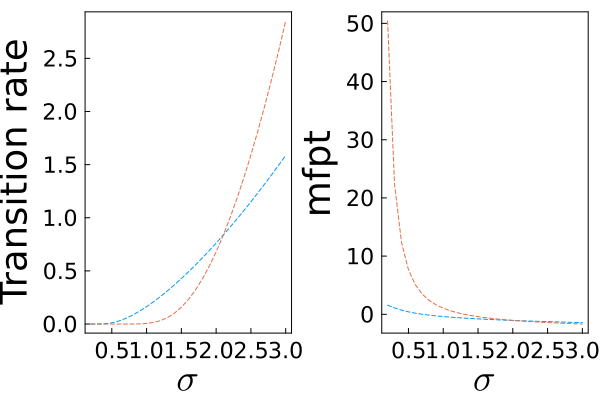

In [21]:
#export transition rate and mfpt
function  give_rate(find_value::Function)
    len = length(0.2:0.1:3.0)
    V_ab = zeros(len)
    Mfpt = zeros(len)
    index = 1
    for i in 0.2:0.1:3.0
        _,_,_,_,_,v_ab, mfpt = find_value(i)
        V_ab[index] = v_ab
        Mfpt[index] = mfpt
        index = index + 1
    end
    return V_ab, Mfpt
end

V_ab_add, Mfpt_add =  give_rate(find_value);
V_ab_mul, Mfpt_mul = give_rate(find_value_mul);

σ = L"σ"
add_noise = L"g(x) = \sigma"
mult_noise = L"g(x) = \frac{\sigma}{4}(x^4-4x^2+8)"
log10_label = L"\log_{10}(\mathrm{mfpt})"
p1 = plot(0.2:0.1:3.0, V_ab_add, xlab = σ, labelsize = 2,  ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legendfont = font(14), label = add_noise, framestyle = :box, size = (600, 400), linestyle = :dash)
plot!(0.2:0.1:3.0, V_ab_mul, label = mult_noise, grid = false, legend = false, foreground_color_legend = nothing, ylab = "Transition rate", linestyle =:dash)
plot(p1, size = (400,400))

p2 = plot(0.2:0.1:3.0, log10.(Mfpt_add), xlab = σ, labelsize = 2,  ytickfont=font(15), xtickfont=font(15), guidefont=font(25), legendfont = font(14), label = add_noise, framestyle = :box, size = (600, 400), linestyle=:dash)
plot!(0.2:0.1:3.0, log10.(Mfpt_mul), label = mult_noise, grid =:false, legend =false, ylab = "mfpt", foreground_color_legend = nothing, linestyle = :dash)
plot(p1, p2)
savefig("figure/trans_rate.pdf")
plot(p1, p2)